In [30]:
#!python -m pip install matplotlib
#!python -m pip install pandas
#!python -m pip install scikit-learn

In [28]:
from os import listdir
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy import stats
from sklearn.decomposition import PCA

In [29]:
# Enable interactive matplotlib plots
%matplotlib inline

In [30]:
# Print versions
!python --version
print('Numpy ' + np.__version__)
print('Pandas ' + pd.__version__)

Python 3.9.2
Numpy 1.23.1
Pandas 1.5.1


In [31]:
# Settings
dataset_path = './data'  # Directory where raw accelerometer data is stored
normal_op_list = ['normal']
anomaly_op_list = ['abnormal']

sample_rate = 128       # Hz
sample_time = 1       # Time (sec) length of each sample
samples_per_file = 200 # Expected number of measurements in each file
max_measurements = int(sample_time * sample_rate)

print('Max measurements per file:', max_measurements)

Max measurements per file: 128


In [32]:
# Create list of filenames
def createFilenameList(op_list):
    
    # Extract paths and filenames in each directory
    op_filenames = []
    num_samples = 0
    for index, target in enumerate(op_list):
        samples_in_dir = listdir(join(dataset_path, target))
        samples_in_dir = [join(dataset_path, target, sample) for sample in samples_in_dir]
        op_filenames.append(samples_in_dir)
    
    # Flatten list
    return [item for sublist in op_filenames for item in sublist]

In [33]:
# Create normal and anomaly filename lists
normal_op_filenames = createFilenameList(normal_op_list)
anomaly_op_filenames = createFilenameList(anomaly_op_list)
print('Number of normal samples:', len(normal_op_filenames))
print('Number of anomaly samples:', len(anomaly_op_filenames))

Number of normal samples: 3
Number of anomaly samples: 3


In [34]:
# Test: list files
normal_op_filenames

['./data/normal/0001.csv', './data/normal/0000.csv', './data/normal/0002.csv']

In [35]:
# Test: list files
anomaly_op_filenames

['./data/abnormal/0003.csv',
 './data/abnormal/0005.csv',
 './data/abnormal/0004.csv']

In [36]:
# Function to plot normal vs anomaly samples side-by-side
def plotTimeSeriesSample(normal_sample, anomaly_sample):
    fig, axs = plt.subplots(2, 1, figsize=(6, 6))
    fig.tight_layout(pad=3.0)
    axs[0].plot(normal_sample.T[0], label='x')
    axs[0].plot(normal_sample.T[1], label='y')
    axs[0].plot(normal_sample.T[2], label='z')
    axs[0].set_title('Normal sample')
    axs[0].set_xlabel('sample')
    axs[0].set_ylabel('G-force')
    axs[0].legend()
    axs[1].plot(anomaly_sample.T[0], label='x')
    axs[1].plot(anomaly_sample.T[1], label='y')
    axs[1].plot(anomaly_sample.T[2], label='z')
    axs[1].set_title('Anomaly sample')
    axs[1].set_xlabel('sample')
    axs[1].set_ylabel('G-force')
    axs[1].legend()

In [37]:
# Function to plot 3D scatterplot of normal and anomaly smaples
def plotScatterSamples(normal_samples, anomaly_samples, num_samples, title=''):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    for i in range(num_samples):
        ax.scatter(normal_samples[i].T[0], normal_samples[i].T[1], normal_samples[i].T[2], c='b')
        ax.scatter(anomaly_samples[i].T[0], anomaly_samples[i].T[1], anomaly_samples[i].T[2], c='r')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title(title)

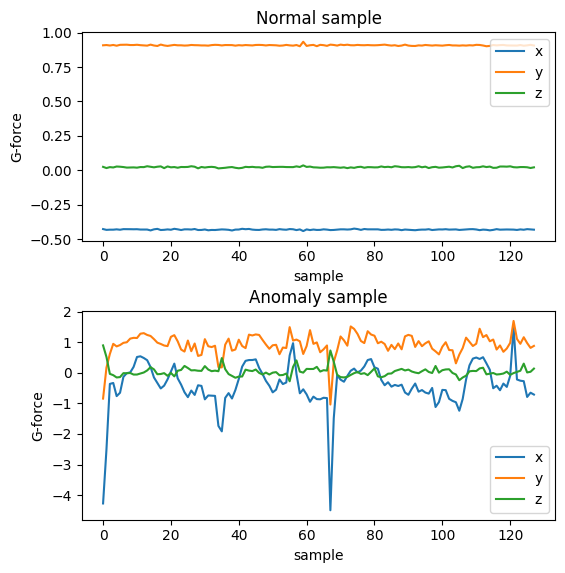

In [38]:
# Examine a normal sample vs anomalous sample
normal_sample = np.genfromtxt(normal_op_filenames[0], delimiter=',')
anomaly_sample = np.genfromtxt(anomaly_op_filenames[0], delimiter=',')

# Plot time series of accelerometer data
plotTimeSeriesSample(normal_sample, anomaly_sample)

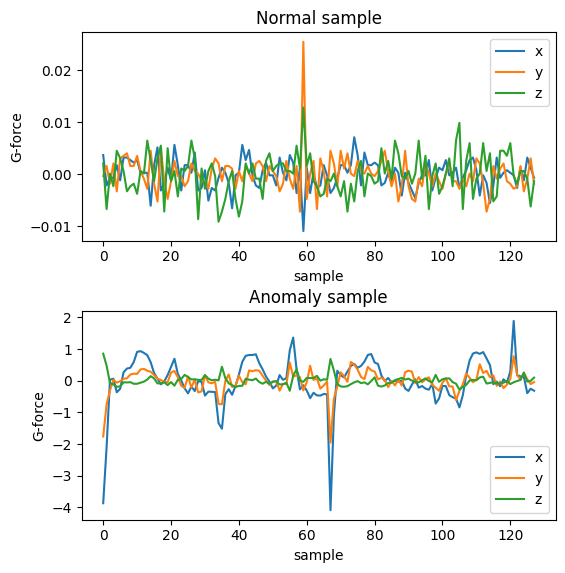

In [39]:
# Let's remove DC to see what it looks like in time domain
normal_sample = np.genfromtxt(normal_op_filenames[0], delimiter=',')
anomaly_sample = np.genfromtxt(anomaly_op_filenames[0], delimiter=',')
normal_sample = normal_sample - np.mean(normal_sample, axis=0)
anomaly_sample = anomaly_sample - np.mean(anomaly_sample, axis=0)

# Plot time series of accelerometer data
plotTimeSeriesSample(normal_sample, anomaly_sample)

In [40]:
# Function: Calculate FFT for each axis in a given sample
def extract_fft_features(sample):

    # Truncate sample size
    sample = sample[0:max_measurements]

    # Crate a window
    hann_window = np.hanning(sample.shape[0])

    # Compute a windowed FFT of each axis in the sample (leave off DC)
    out_sample = np.zeros((int(sample.shape[0] / 2), sample.shape[1]))
    for i, axis in enumerate(sample.T):
        fft = abs(np.fft.rfft(axis * hann_window))
        out_sample[:, i] = fft[1:]

    return out_sample

In [41]:
# Test: Compute FFTs (without DC) for samples and average them together
num_samples = 3
normal_ffts = []
anomaly_ffts = []
for i in range(num_samples):
    normal_sample = np.genfromtxt(normal_op_filenames[i], delimiter=',')
    print(normal_sample.shape)
    anomaly_sample = np.genfromtxt(anomaly_op_filenames[i], delimiter=',')
    normal_fft = extract_fft_features(normal_sample)
    anomaly_fft = extract_fft_features(anomaly_sample)
    normal_ffts.append(normal_fft)
    anomaly_ffts.append(anomaly_fft)
normal_ffts = np.array(normal_ffts)
anomaly_ffts = np.array(anomaly_ffts)
normal_fft_avg = np.average(normal_ffts, axis=0)
anomaly_fft_avg = np.average(anomaly_ffts, axis=0)
print(normal_fft_avg.shape)

(128, 3)
(128, 3)
(128, 3)
(64, 3)


(64, 3)


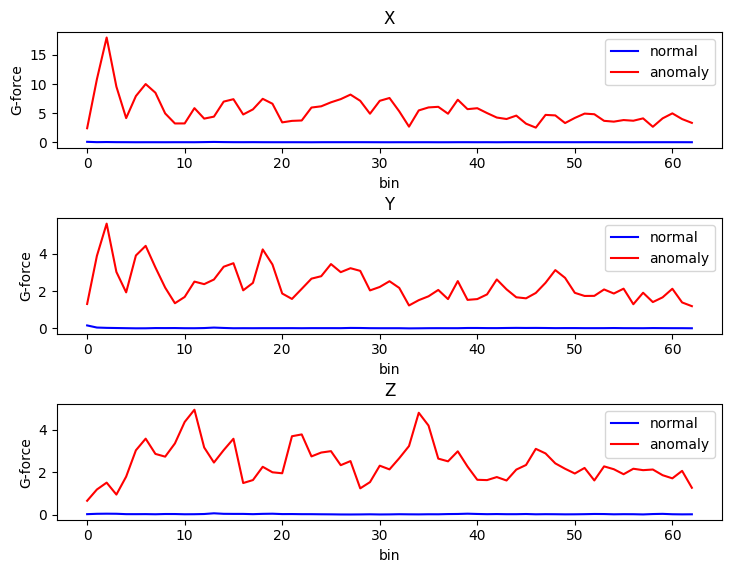

In [42]:
# Plot FFTs
start_bin = 1
fig, axs = plt.subplots(3, 1, figsize=(8, 6))
fig.tight_layout(pad=3.0)
print(normal_fft_avg.shape)
axs[0].plot(normal_fft_avg[start_bin:, 0], label='normal', color='blue')
axs[0].plot(anomaly_fft_avg[start_bin:, 0], label='anomaly', color='red')
axs[0].set_title('X')
axs[0].set_xlabel('bin')
axs[0].set_ylabel('G-force')
axs[0].legend()

axs[1].plot(normal_fft_avg[start_bin:, 1], label='normal', color='blue')
axs[1].plot(anomaly_fft_avg[start_bin:, 1], label='anomaly', color='red')
axs[1].set_title('Y')
axs[1].set_xlabel('bin')
axs[1].set_ylabel('G-force')
axs[1].legend()

axs[2].plot(normal_fft_avg[start_bin:, 2], label='normal', color='blue')
axs[2].plot(anomaly_fft_avg[start_bin:, 2], label='anomaly', color='red')
axs[2].set_title('Z')
axs[2].set_xlabel('bin')
axs[2].set_ylabel('G-force')
axs[2].legend()

how to implement fft on python

In [27]:
normal_ffts_new = []
normal_sample = np.genfromtxt("./data/normal/0000.csv", delimiter=',')
#normal_sample = np.genfromtxt("..//datasets//ceiling-fan//fan_0_low_0_weight-moving//0000.csv", delimiter=',')
print(normal_sample.shape)
normal_fft = extract_fft_features(normal_sample)
normal_ffts_new.append(normal_fft)
normal_ffts_new = np.array(normal_ffts_new)
normal_fft_avg_new = np.average(normal_ffts_new, axis=0)
print(normal_fft_avg.shape)

(128, 3)
(64, 3)
